<a href="https://colab.research.google.com/github/angelinasinaga/Indonesian_Named-entity_Recognition/blob/main/Pasupasu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. LOAD DATA** ##

**1.1 Import Libraries**

In [7]:
#Data analysis   
import pandas as pd 
import numpy as np
import csv
import nltk
import tensorflow as tf

In [8]:
#Data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
from matplotlib import ticker
%config InlineBackend.figure_format = 'svg'

In [9]:
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [10]:
!pip install eli5

In [11]:
# from sklearn_crfsuite import CRF, scorers, metrics
# import sklearn_crfsuite
# from sklearn_crfsuite import scorers
# from sklearn_crfsuite import metrics
# from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

**1.2 Load Data**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
list_kalimat = []
nomor_kalimat = 1

# open file in read mode
with open('/content/drive/MyDrive/ProyekPBA/SINGGALANG.tsv.csv', encoding='UTF-8') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj, delimiter='\t', quotechar=None) #https://www.petanikode.com/python-csv/ 
# https://docs.python.org/id/3.9/library/csv.html
# Menginstruksikan reader untuk tidak melakukan pemrosesan khusus terhadap karakter kutipan
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        # row variable is a list that represents a row in csv
        if len(row) == 0:
            nomor_kalimat += 1 
        else:
            tmp_row= row
            tmp_row.append(nomor_kalimat)
            list_kalimat.append(tmp_row)

dataset = pd.DataFrame(list_kalimat, columns=['token', 'entitas bernama', 'kalimat'])

In [14]:
dataset.head()

,token,entitas bernama,kalimat
0,"""Ia","O""",1.0
1,"""menjabat","O""",1.0
2,"""sebagai","O""",1.0
3,"""Presiden","O""",1.0
4,"""ketiga","O""",1.0


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641099 entries, 0 to 641098
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   token            641099 non-null  object 
 1   entitas bernama  641099 non-null  object 
 2   kalimat          620920 non-null  float64
dtypes: float64(1), object(2)
memory usage: 14.7+ MB


## **2. Exploring / Visualisasi Data (Analisis Data)** ##

Membangun kelas sederhana untuk menggabungkan kata-kata ke dalam kalimat. 

In [16]:
print("Jumlah kalimat: ", len(dataset.groupby(['kalimat'])))
words = list(set(dataset["token"].values))
n_words = len(words)
print("Jumlah kata unik : ", n_words)
tags = list(set(dataset["entitas bernama"].values))
print("Entitas bernama:", tags)
n_tags = len(tags)
print("Jumlah entitas bernama: ", n_tags)

Jumlah kalimat:  1
Jumlah kata unik :  57787
Entitas bernama: [1, 'Place"', 'O"', 'Organisation"', 'Person"']
Jumlah entitas bernama:  5


In [17]:
#Words tagged as Place
dataset.loc[dataset['entitas bernama'] == 'Place', 'token'].head()

Series([], Name: token, dtype: object)

In [18]:
#Words tagged as Person
dataset.loc[dataset['entitas bernama'] == 'Person', 'token'].head()

Series([], Name: token, dtype: object)

In [19]:
#Words tagged as Organisation
dataset.loc[dataset['entitas bernama'] == 'Organisation', 'token'].head()

Series([], Name: token, dtype: object)

In [20]:
#Words tagged as O
dataset.loc[dataset['entitas bernama'] == 'O', 'token'].head()

Series([], Name: token, dtype: object)

**Menghitung Jumlah Entitas Bernama**

In [21]:
dataframe = dataset.groupby("entitas bernama" )
dataframe["entitas bernama"].count() 

entitas bernama
1                 20179
O"               559536
Organisation"      5125
Person"           14278
Place"            41981
Name: entitas bernama, dtype: int64

**Menampilkan 20 token pertama yang paling banyak muncul**

In [22]:
dataset['token'].value_counts()[:20]

",          37710
".          20191
""          20146
"dan        16178
"di         13995
"yang       13322
"-LRB-       8546
"-RRB-       8511
"dengan      6687
"dari        6364
"pada        5749
"''          5596
"``          5283
"tahun       4463
"ini         3701
"sebagai     3462
"adalah      3314
"menjadi     3174
"untuk       3095
"dalam       3019
Name: token, dtype: int64

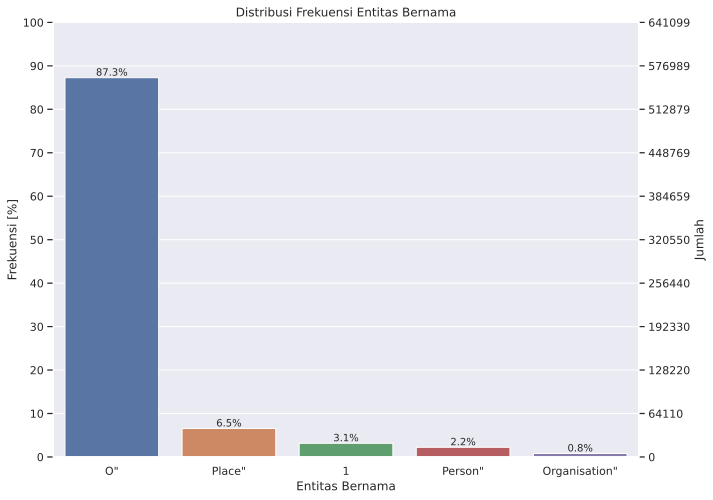

In [23]:
ncount = len(dataset)

plt.figure(figsize=(10.5, 8))
ax = sns.countplot(x = "entitas bernama", data = dataset)
plt.title('Distribusi Frekuensi Entitas Bernama')
plt.xlabel('Entitas Bernama')

# Buat twin axis
ax2 = ax.twinx()

# Tukar sehingga count axis di kanan, frequency di kiri
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Tukar juga label
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax.set_ylabel('Jumlah')
ax2.set_ylabel('Frekuensi [%]')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha = 'center', va = 'bottom') # atur alignment teks

# Gunakan LinearLocator untuk memastikan jumlah tick yang benar
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Perbaiki rentang frekuensi menjadi 0-100
ax2.set_ylim(0, 100)
ax.set_ylim(0, ncount)

# Gunakan MultipleLocator untuk memastikan spaci antar-tick yaitu 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Atur sehingga grid pada ax2 off, supaya gridlines tidak ditampilkan
# pada bagian atas bar
ax2.grid(None)

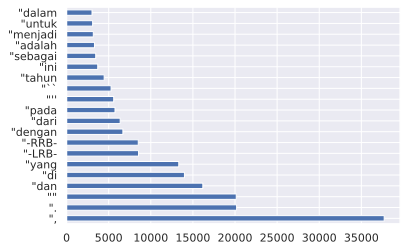

In [24]:
# Visualisasi data 20 token yang paling banyak muncul
dataset['token'].value_counts()[:20].plot(kind='barh')

In [26]:
# Menghitung jumlah punctuation
dataset_punct = open('/content/drive/MyDrive/ProyekPBA/SINGGALANG.tsv.csv').read()

dataset_punct  = dataset_punct.replace("--", " ")

for symbol in "-'":
   dataset_punct  = dataset_punct.replace(symbol + " ", "")
   dataset_punct  = dataset_punct.replace(" " + symbol, "")

for symbol in ".,/'-":
    print (symbol, dataset_punct.count(symbol)) 

. 23907
, 38389
/ 1263
' 12054
- 41681


## **3. Text Preprocessing** ##

*   Expand Contraction





In [27]:
dataset_prep = pd.DataFrame(list_kalimat, columns=['token', 'entitas bernama', 'kalimat'])

In [30]:
#Memperbaiki format penulisan pada kolom token
# re.sub = setiap string yang sesuai dengan pola akan digantikan dengan string yang kita inginkan.
# re.search = searches for that pattern within the string.
import re
def perbaikan_format_tanda_baca(dataset_prep):    
    for i in dataset_prep.index:
        token = re.sub('([.,!?()])', r'\1 ', dataset_prep.at[i, 'token'])
        dataset_prep.at[i, 'token'] = re.sub('\s{2,}', ' ', token)
    return dataset_prep
perbaikan_format_tanda_baca(dataset_prep)

,token,entitas bernama,kalimat
0,"""Ia","O""",1.0
1,"""menjabat","O""",1.0
2,"""sebagai","O""",1.0
3,"""Presiden","O""",1.0
4,"""ketiga","O""",1.0
...,...,...,...
641094,"""dari","O""",1.0
641095,"""jawa","O""",1.0
641096,""",","O""",1.0
641097,"""mereka","O""",1.0
